In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
import cv2
import skimage.io
from tqdm.notebook import tqdm
import zipfile
import numpy as np
import torchvision.models as models
import torch.nn as nn

In [40]:
train_df = pd.read_csv('/kaggle/input/prostate-cancer-grade-assessment/train.csv')


In [41]:
train_df = shuffle(train_df)
training_item_count = int(len(train_df) * 0.8)
validation_df = train_df[training_item_count:]
train_df = train_df[:training_item_count]

In [42]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score
3822,5f537ae857febf9281dd301fd9ccb5f2,radboud,0,negative
3500,577a95c3a3a0fb362b7282fdf9311015,radboud,5,4+5
4356,6bfa122b5832ffd442a8123153f5d252,radboud,0,negative
3963,62a348a227dfe4006295ea31ce48c4b3,karolinska,1,3+3
1828,2e20fa4b5612ba96f79c29cbd9635dfc,karolinska,4,4+4


In [46]:
id = 'c66e1872348e07fc4f01feeb5eecb7f8'

img = '/kaggle/input/prostate-cancer-grade-assessment/train_images/'+id+'.tiff'
msk = '/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/' +id+'_mask.tiff'
out = 4

img = skimage.io.MultiImage(img)[-1]
msk = skimage.io.MultiImage(msk)[-1]


In [36]:
img.shape, msk.shape

((32512, 26624, 3), (32512, 26624, 3))

In [76]:
sz = 128
N = 16
TRAIN = '/kaggle/input/prostate-cancer-grade-assessment/train_images'
MASKS = '/kaggle/input/prostate-cancer-grade-assessment/train_label_masks'

def tile(img,mask):
    result = []
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                constant_values=255)
    mask = np.pad(mask,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                constant_values=0)
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    mask = mask.reshape(mask.shape[0]//sz,sz,mask.shape[1]//sz,sz,3)
    mask = mask.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    if len(img) < N:
        mask = np.pad(mask,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=0)
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)
    #idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    print(mask.reshape(mask.shape[0],-1).sum(-1).shape)
    idxs = np.argsort(mask.reshape(mask.shape[0],-1).sum(-1))[::-1][:N]
    img = img[idxs]
    mask = mask[idxs]
    for i in range(len(img)):
        result.append({'img':img[i], 'mask':mask[i], 'idx':i})
    return result

In [77]:
msk[msk>2] = 2
res = tile(img,msk)

(52832,)


In [45]:
len(res),res[0]['img'].shape,res[0]['mask'].shape

(16, (128, 128, 3), (128, 128, 3))

In [90]:
names = [name[:-10] for name in os.listdir(MASKS)]
len(names)

10516

In [91]:
print(len(train_df))
train_df.head(5)

8492


,image_id,data_provider,isup_grade,gleason_score,gleason_score_numeric
8220,c66e1872348e07fc4f01feeb5eecb7f8,karolinska,4,4+4,8.0
8628,d0115a12026bc4b8a10ad05fe4992ded,radboud,3,4+3,7.0
3423,5576eab39cdad6279ed218eb398d06dc,karolinska,0,0+0,0.0
2081,342b38a965d96d8e8b606ade1094e96e,karolinska,1,3+3,6.0
4816,77087895140c470801c962615845e36a,karolinska,0,0+0,0.0


In [39]:
train_df = train_df[train_df['image_id'].isin(names)]
train_df = train_df.groupby('isup_grade').apply(lambda x: x.sample(30)).reset_index(drop=True)
print(len(train_df))


results = []
outputs = []
for i in tqdm(range(len(train_df))):
    img = skimage.io.MultiImage(os.path.join(TRAIN, train_df['image_id'].iloc[i] + '.tiff'))[-1]
    result = tile(img,mask)
    results.append(result)
    outputs.append(train_df['isup_grade'].iloc[i])


NameError: name 'train_df' is not defined

In [103]:
import pickle 
filehandler = open("/kaggle/working/results.obj","wb")
pickle.dump(results, filehandler)

filehandler = open("/kaggle/working/outputs.obj","wb")
pickle.dump(outputs, filehandler)

In [21]:
import pickle
results = pickle.load(open('/kaggle/working/results.obj','rb'))
outputs = pickle.load(open('/kaggle/working/outputs.obj','rb'))
len(outputs), len(results)

EOFError: Ran out of input

In [22]:
len(results)

180

In [28]:
N=16
img_res = [results[0][i]['img'] for i in range(N)]

In [29]:
img_res = torch.tensor(np.array(img_res)).view((16,3,128,128))

In [37]:
# classfication 

# model x 16 -> Pooling of Feature Vectors -> Classification.  (Quadratic Weighted Kappa)


def build_model_feature(pretrained=True, fine_tune=True,):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model = models.efficientnet_b6()
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
    # Change the final classification head.
    model.classifier = nn.Identity()
    # model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    return model

def pool_patches(model, patches):
    outputs = model(patches)
    pooled_output = torch.mean(outputs, dim=0) # Average pooling
    return pooled_output

class efficienet_pool(nn.Module):
    def __init__(self, model):
        super(efficienet_pool, self).__init__()
        self.model = model
    def forward(self, x):
        x = self.model(x)
        # group by 16 and take the mean
        x = x.view(-1, N, x.size(1))
        x = torch.mean(x, dim=1)
        return x
    
model = build_model_feature()
model = efficienet_pool(model)


[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...


In [32]:
import torch
from torchvision import transforms
from PIL import Image

# Assuming 'image' is a numpy array
# Convert it to a PIL Image

# Define transformation to apply to the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the input size expected by the model
])

# Apply transformation to the image
image_tensor = transform(img_res)
# model(img_res.view((16,3,128,128)))

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [33]:
image_tensor.shape, type(image_tensor)

(torch.Size([16, 3, 224, 224]), torch.Tensor)

In [34]:
out = model(image_tensor.float())

In [36]:
out

tensor([[0.1117, 0.1077, 0.1085,  ..., 0.1205, 0.1039, 0.1197]],
       grad_fn=<MeanBackward1>)

In [18]:
def build_model(pretrained=True, fine_tune=True, num_classes=6):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model = models.efficientnet_b6(pretrained=pretrained)
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
    # Change the final classification head.
    model.classifier = nn.Identity()
    # model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    return model



In [19]:
model = build_model()

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...


In [49]:
import torch
from torchvision import transforms
from PIL import Image

# Assuming 'image' is a numpy array
# Convert it to a PIL Image
image_pil = Image.fromarray(img)

# Define transformation to apply to the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the input size expected by the model
    transforms.ToTensor(),  # Convert PIL Image to tensor
])

# Apply transformation to the image
image_tensor = transform(image_pil)

In [50]:
image_tensor_batched = image_tensor.unsqueeze(0)  
output=model(image_tensor_batched)

RuntimeError: shape '[-1, 16, 2304]' is invalid for input of size 2304

In [51]:
image_tensor_batched.shape

torch.Size([1, 3, 224, 224])

In [57]:
img_res.view((16,3,128,128)).shape

torch.Size([16, 3, 128, 128])

In [23]:
output.shape

torch.Size([1, 2304])

In [3]:

def build_model_feature(pretrained=True, fine_tune=True,):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model = models.efficientnet_b6(pretrained=pretrained)
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
    # Change the final classification head.
    model.classifier = nn.Identity()
    # model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    return model

def pool_patches(model, patches):
    outputs = model(patches)
    pooled_output = torch.mean(outputs, dim=0) # Average pooling
    return pooled_output



[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...


AttributeError: _fc

In [ ]:
def model(img):
    plt.figure()
    plt.imshow(img[0]['img'])
    print("[INFO] passing each patch through model")
    time.sleep(10)
    print(img[0]['img'].shape)
    print("[INFO] pooling and inference")
    time.sleep(5)
    l = random.randint(0,6)
    return {"true label": l, "prediction": l}

In [195]:
import torch
import argparse
import torch.nn as nn
import torch.optim as optim
import time
from tqdm.auto import tqdm
import time
import random 


def train(model, images, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for data in tqdm(iamges):
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc



In [187]:
# Validation function.
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [188]:
train_loader, valid_loader =

# Learning_parameters. 
lr = args['learning_rate']
epochs = args['epochs']
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")
print(f"Learning rate: {lr}")
print(f"Epochs to train for: {epochs}\n")
model = build_model(
    pretrained=args['pretrained'], 
    fine_tune=True, 
    num_classes=len(dataset_classes)
).to(device)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# Optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr)
# Loss function.
criterion = nn.CrossEntropyLoss()
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                            optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    time.sleep(5)
    

# Save the trained model weights.
save_model(epochs, model, optimizer, criterion, args['pretrained'])
# Save the loss and accuracy plots.
save_plots(train_acc, valid_acc, train_loss, valid_loss, args['pretrained'])
print('TRAINING COMPLETE')

SyntaxError: invalid syntax (3101513260.py, line 1)

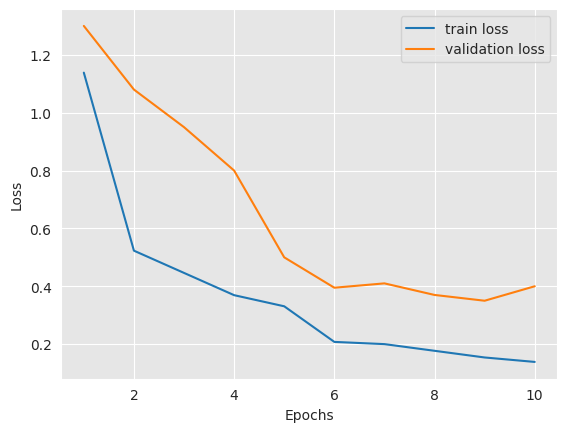

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid',{'figure.facecolor': 'white','axes.facecolor':'.9'})

plt.plot(range(1,11),a, label = 'train loss')
plt.plot(range(1,11),b, label='validation loss')

plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [205]:
def tile(img,mask):
    print("[INFO] making patches")
    result = []
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                constant_values=255)
    mask = np.pad(mask,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                constant_values=0)
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    mask = mask.reshape(mask.shape[0]//sz,sz,mask.shape[1]//sz,sz,3)
    mask = mask.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    if len(img) < N:
        mask = np.pad(mask,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=0)
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    print(mask.reshape(mask.shape[0],-1).sum(-1).shape)
    #idxs = np.argsort(mask.reshape(mask.shape[0],-1).sum(-1))[::-1][:N]
    print("indices", idxs.shape)
    img = img[idxs]
    mask = mask[idxs]
    for i in range(len(img)):
        result.append({'img':img[i], 'mask':mask[i], 'idx':i})
    return result

In [ ]:
def predict(image):
    patches = tile(image,image)
    return model(patches)

print(predict(img))

[INFO] making patches
(18368,)
indices (16,)


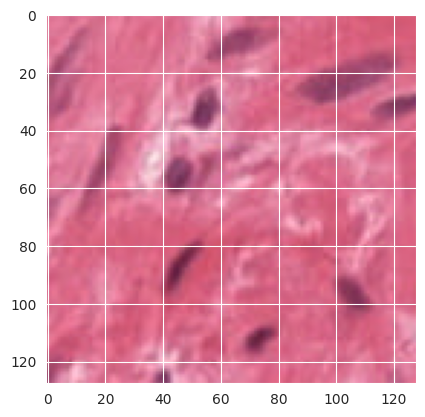

In [206]:
patches = tile(img,img)
plt.imshow(patches[0]['img'])

In [204]:
patches[0]['img']

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]